# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
# YOUR CODE HERE!
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_price = requests.get(btc_url).json()

# Fetch current ETH price
eth_price = requests.get(eth_url).json()

# Compute current value of my crpto
# Contradicting instructions were given to us. In one area it asked us to find values in Canadian dollars and in the other it asked us to find values in US dollars.
# Since we will be adding the cryptocurrency values with stock values later, and since SPY and AGG will give us values in US dollars, I will obtain all values in US dollars from now on to avoid any currency conversion. 
my_btc_value = float(btc_price['data']['1']['quotes']['USD']['price']) * my_btc
my_eth_value = float(eth_price['data']['1027']['quotes']['USD']['price']) * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f} USD")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f} USD")

The current value of your 1.2 BTC is $52669.20 USD
The current value of your 5.3 ETH is $11895.74 USD


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
api_key = os.getenv('ALPACA_API_KEY')
api_secret_key = os.getenv('ALPACA_SECRET_KEY')
# Create the Alpaca API object
alpaca = tradeapi.REST(api_key, api_secret_key, api_version = 'v2')

In [8]:
# Format current date as ISO format
current_date = pd.Timestamp.today(tz = 'America/New_York').isoformat()
# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df = alpaca.get_bars(tickers, timeframe, start = '2023-12-28', end = '2023-12-28').df # Picked Dec 28th 2023 for the date.

# Reorganize the DataFrame
# Separate ticker data
AGG_df = df[df['symbol'] == 'AGG'].drop('symbol', axis = 1)
SPY_df = df[df['symbol'] == 'SPY'].drop('symbol', axis = 1)

# Concatenate the ticker DataFrames
concat_df = pd.concat([AGG_df, SPY_df], axis = 1, keys = ['AGG', 'SPY'])
# Preview DataFrame
concat_df

AGG                                              \
                           close   high      low trade_count   open   volume   
timestamp                                                                      
2023-12-28 05:00:00+00:00  99.44  99.65  99.3127       25735  99.54  7172285   

                                         SPY                              \
                                vwap   close    high     low trade_count   
timestamp                                                                  
2023-12-28 05:00:00+00:00  99.454329  476.69  477.55  476.26      374241   

                                                         
                             open    volume        vwap  
timestamp                                                
2023-12-28 05:00:00+00:00  476.88  77158117  476.774686

In [9]:
# Pick AGG and SPY close prices
agg_close_price = concat_df['AGG']['close'].iloc[0]
spy_close_price = concat_df['SPY']['close'].iloc[0]
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price} USD")
print(f"Current SPY closing price: ${spy_close_price} USD")

Current AGG closing price: $99.44 USD
Current SPY closing price: $476.69 USD


In [10]:
# Compute the current value of shares
my_spy_value = my_spy * float(spy_close_price)
my_agg_value = my_agg * float(agg_close_price)
# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f} USD")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f} USD")

The current value of your 50 SPY shares is $23834.50 USD
The current value of your 200 AGG shares is $19888.00 USD


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000
# Consolidate financial assets data
total_values = {'amount': [my_btc_value + my_eth_value, my_spy_value + my_agg_value]}
columns = ['crypto', 'shares']
# Create savings DataFrame
df_savings = pd.DataFrame(total_values, index = columns)
# Display savings DataFrame
display(df_savings)

,amount
crypto,64564.944
shares,43722.500


<Axes: ylabel='amount'>

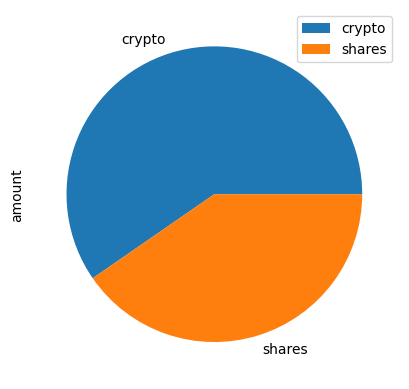

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y = 'amount')

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = my_btc_value + my_eth_value + my_agg_value + my_spy_value
# Validate saving health
def enough_fund_checker(savings):
    if savings > emergency_fund:
        print('Congratulations. You have enough money.')
    elif savings == emergency_fund:
        print('Congratulations. You have reached your financial goal.')
    else:
        print(f'You still need ${emergency_fund - savings} to reach your goal')

# Check our saving health
enough_fund_checker(total_savings)


Congratulations. You have enough money.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of ten years back from today. (Instruction asked us to get 10 years worth historical closing data)
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2013-12-28', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2023-12-28', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
tickers = ["AGG", "SPY"]
monte_carlo_df = alpaca.get_bars(tickers, timeframe, start = start_date, end = end_date).df

# Reorganize the DataFrame
# Separate ticker data
monte_carlo_AGG = monte_carlo_df[monte_carlo_df['symbol'] == 'AGG'].drop('symbol', axis = 1)
monte_carlo_SPY = monte_carlo_df[monte_carlo_df['symbol'] == 'SPY'].drop('symbol', axis = 1)
# Concatenate the ticker DataFrames
df_stock_data = pd.concat([monte_carlo_AGG, monte_carlo_SPY], axis = 1, keys = ['AGG', 'SPY'])
# Display sample data
df_stock_data.head()

AGG                                      \
                            close    high     low trade_count    open   
timestamp                                                               
2016-01-04 05:00:00+00:00  107.97  108.29  107.93       14860  108.09   
2016-01-05 05:00:00+00:00  108.02  108.12  107.87        8860  107.87   
2016-01-06 05:00:00+00:00  108.43  108.46  108.22       13183  108.35   
2016-01-07 05:00:00+00:00  108.42  108.47  108.21       12305  108.40   
2016-01-08 05:00:00+00:00  108.66  108.71  108.35       11442  108.57   

                                                     SPY                  \
                            volume        vwap     close    high     low   
timestamp                                                                  
2016-01-04 05:00:00+00:00  3821479  108.078566  201.0192  201.03  198.59   
2016-01-05 05:00:00+00:00  2757684  107.990501  201.3600  201.90  200.05   
2016-01-06 05:00:00+00:00  3048156  108.363216  198.8200  200.06  197.60   
2016-01-07 05:00:00+00:00  2530827  108.368381  194.0500  197.44  193.59   
2016-01-08 05:00:00+00:00  4047091  108.587804  191.9230  195.85  191.58   

                                                                       
                          trade_count     open     volume        vwap  
timestamp                                                              
2016-01-04 05:00:00+00:00      655489  200.490  225903783  200.656423  
2016-01-05 05:00:00+00:00      418709  201.405  112719152  201.084280  
2016-01-06 05:00:00+00:00      548386  198.330  153948196  198.956460  
2016-01-07 05:00:00+00:00      796451  195.330  216191953  195.345911  
2016-01-08 05:00:00+00:00      754102  195.190  216105404  193.644537

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
# 40% weight to 'AGG', 60% weight to 'SPY' are given, and we are running simulation for 500 times for 30 years.
MC_thirty_years = MCSimulation(portfolio_data = df_stock_data, weights = [0.4, 0.6], num_simulation = 500, num_trading_days = 252*30)

In [17]:
# Printing the simulation input data
MC_thirty_years.portfolio_data.head()

AGG                                      \
                            close    high     low trade_count    open   
timestamp                                                               
2016-01-04 05:00:00+00:00  107.97  108.29  107.93       14860  108.09   
2016-01-05 05:00:00+00:00  108.02  108.12  107.87        8860  107.87   
2016-01-06 05:00:00+00:00  108.43  108.46  108.22       13183  108.35   
2016-01-07 05:00:00+00:00  108.42  108.47  108.21       12305  108.40   
2016-01-08 05:00:00+00:00  108.66  108.71  108.35       11442  108.57   

                                                                  SPY          \
                            volume        vwap daily_return     close    high   
timestamp                                                                       
2016-01-04 05:00:00+00:00  3821479  108.078566          NaN  201.0192  201.03   
2016-01-05 05:00:00+00:00  2757684  107.990501     0.000463  201.3600  201.90   
2016-01-06 05:00:00+00:00  3048156  108.363216     0.003796  198.8200  200.06   
2016-01-07 05:00:00+00:00  2530827  108.368381    -0.000092  194.0500  197.44   
2016-01-08 05:00:00+00:00  4047091  108.587804     0.002214  191.9230  195.85   

                                                                               \
                              low trade_count     open     volume        vwap   
timestamp                                                                       
2016-01-04 05:00:00+00:00  198.59      655489  200.490  225903783  200.656423   
2016-01-05 05:00:00+00:00  200.05      418709  201.405  112719152  201.084280   
2016-01-06 05:00:00+00:00  197.60      548386  198.330  153948196  198.956460   
2016-01-07 05:00:00+00:00  193.59      796451  195.330  216191953  195.345911   
2016-01-08 05:00:00+00:00  191.58      754102  195.190  216105404  193.644537   

                                        
                          daily_return  
timestamp                               
2016-01-04 05:00:00+00:00          NaN  
2016-01-05 05:00:00+00:00     0.001695  
2016-01-06 05:00:00+00:00    -0.012614  
2016-01-07 05:00:00+00:00    -0.023992  
2016-01-08 05:00:00+00:00    -0.010961

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995524,0.989051,1.011812,1.002338,0.991031,1.000139,0.997240,0.998929,1.004731,0.996371,...,0.993381,1.013305,1.004872,1.001334,1.012075,1.000364,0.991350,1.002130,0.990253,1.000322
2,0.988212,0.994869,1.017000,0.988357,0.998761,1.008448,1.000590,1.010435,0.989313,1.002601,...,0.997310,1.016979,0.992727,0.992788,1.010347,1.000543,0.998022,1.003354,0.984391,1.006011
3,0.975031,0.991228,1.025958,0.977719,1.004404,1.010535,0.993902,1.009803,1.000340,1.003164,...,1.005998,1.013412,0.991438,0.978666,1.021153,0.999624,0.996933,1.006093,0.993904,1.005621
4,0.971112,1.000265,1.029886,0.959532,1.001194,1.014254,0.995911,0.999525,1.006984,0.998710,...,1.009189,1.021995,0.991443,0.989957,1.010195,1.003385,0.988354,0.994103,0.998628,0.995587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,12.742061,4.804994,11.907370,6.616745,9.939427,4.186491,1.911623,13.056350,4.967914,2.693942,...,1.930161,20.065495,5.264490,6.718793,2.988610,7.164576,3.734277,10.721640,3.402037,5.400320
7557,12.817991,4.799503,11.829969,6.674443,9.939581,4.232039,1.920684,13.054570,5.012692,2.675377,...,1.921000,19.957433,5.246037,6.743863,2.996004,7.149077,3.738236,10.783416,3.423299,5.402879
7558,12.779863,4.839930,11.834119,6.743739,10.028512,4.223964,1.937176,12.977498,4.924373,2.679415,...,1.940095,19.680774,5.256606,6.784471,3.007560,7.127325,3.749420,10.803440,3.469845,5.346217
7559,12.786072,4.829325,11.803380,6.713578,10.056207,4.230155,1.963412,12.996060,4.882283,2.673627,...,1.947774,19.743694,5.260185,6.696186,3.031061,7.237177,3.749047,10.886325,3.481475,5.431544


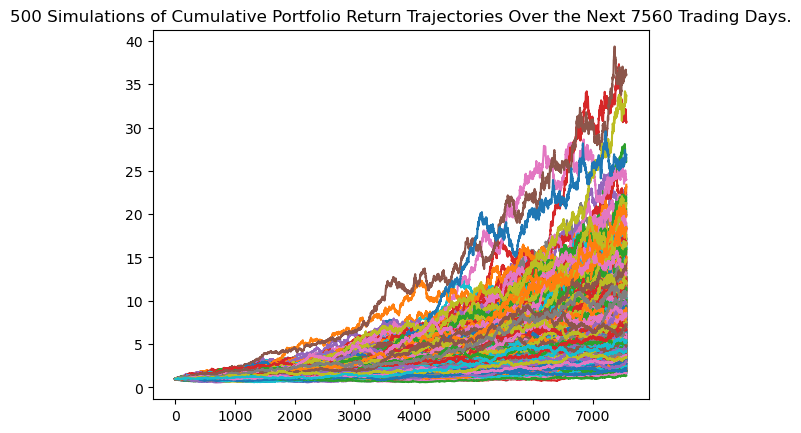

In [19]:
# Plot simulation outcomes
line_plot = MC_thirty_years.plot_simulation()
#line_plot.get_figure().savefig("MC_thirtyyears_sim_plot.png", bbox_inches="tight")

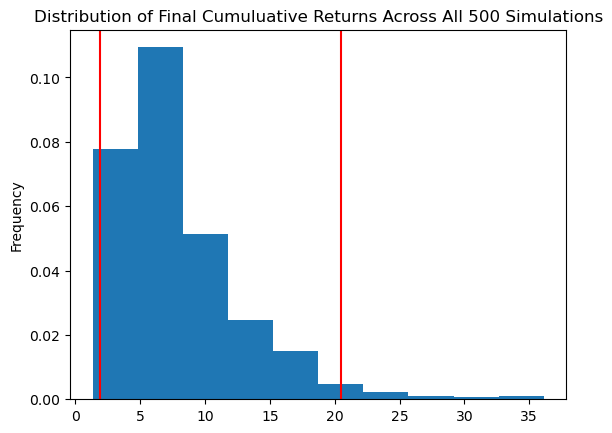

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirty_years.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_thirty_years.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              7.953307
std               4.957403
min               1.358836
25%               4.663269
50%               6.632740
75%               9.915758
max              36.111521
95% CI Lower      1.943063
95% CI Upper     20.475184
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]* initial_investment, 2)
ci_upper = round(tbl[9] * initial_investment, 2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $38861.26 and $409503.68


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment. 50% increament of initial investment of $20,000 will be $30,000
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]* initial_investment, 2)
ci_upper = round(tbl[9] * initial_investment, 2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $58291.89 and $614255.51


#### Optional calculation of expected portfolio return using initial investment of $60,000 in order to answer later question

In [24]:
# This section is an optional calculation in order to answer the very last question in this document

# Set initial investment.
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]* initial_investment, 2)
ci_upper = round(tbl[9] * initial_investment, 2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 30 years will end within in the range of $116583.78 and $1228511.03


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [25]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# 20% weight to 'AGG', 80% weight to 'SPY' are given, and we are running simulation for 500 times for 5 years.
MC_five_years = MCSimulation(portfolio_data = df_stock_data, weights = [0.2, 0.8], num_simulation = 500, num_trading_days = 252*5)

In [26]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011089,0.997581,0.996689,0.992604,1.002833,0.984185,0.994867,1.019940,1.014801,0.984372,...,1.009808,0.989036,0.990915,1.006346,0.992339,0.997522,0.989126,0.997349,1.006424,0.992887
2,1.013771,1.012785,1.002314,0.983504,1.006402,0.991736,0.995287,1.021727,1.023588,0.992190,...,0.987867,0.982950,1.000046,1.015520,0.983894,1.003600,0.987401,1.001530,1.003708,1.006522
3,1.020941,1.029205,1.002652,0.988917,1.006704,0.987182,0.994340,1.027548,1.013218,1.000677,...,0.999784,0.987943,1.006819,1.013546,0.972168,1.019557,0.992795,1.002749,1.020059,1.000439
4,1.010217,1.024460,0.997022,0.983838,1.013318,0.988959,0.985406,1.022626,1.018865,0.996331,...,0.997947,0.976510,0.999844,1.028497,0.987617,1.015751,0.990525,1.006043,1.026330,0.998666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.828878,2.722256,0.870765,0.939646,1.976823,2.323331,1.401966,1.039382,0.873966,2.406471,...,1.504367,0.901129,0.862096,1.588171,1.249513,1.612325,2.314404,1.458450,1.908787,1.953266
1257,1.826780,2.711517,0.878475,0.944172,1.971807,2.334224,1.388827,1.063195,0.866217,2.403364,...,1.505440,0.900889,0.877796,1.591035,1.241744,1.636128,2.303277,1.470952,1.900262,1.941493
1258,1.836896,2.705092,0.868060,0.946421,1.963674,2.323207,1.374084,1.058476,0.876584,2.414702,...,1.505043,0.885939,0.890083,1.588787,1.241080,1.630343,2.298010,1.458897,1.919677,1.918272
1259,1.813665,2.725505,0.870588,0.947963,1.987233,2.284714,1.383344,1.076635,0.871848,2.383246,...,1.500691,0.884908,0.900843,1.594525,1.236933,1.604015,2.299672,1.456322,1.909848,1.912933


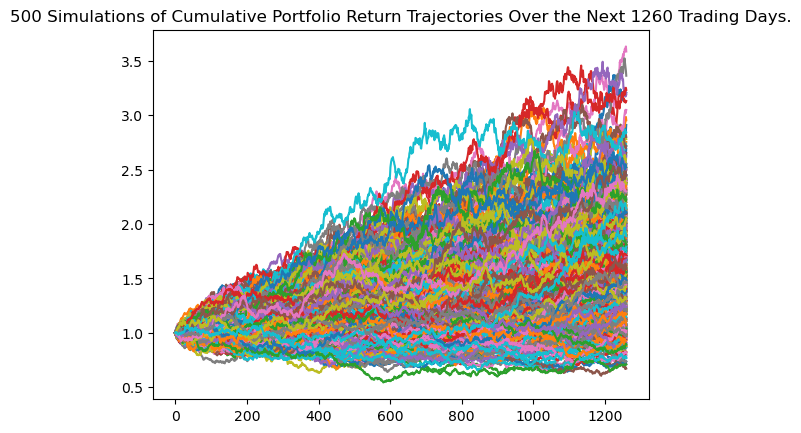

In [27]:
# Plot simulation outcomes
line_plot = MC_five_years.plot_simulation()

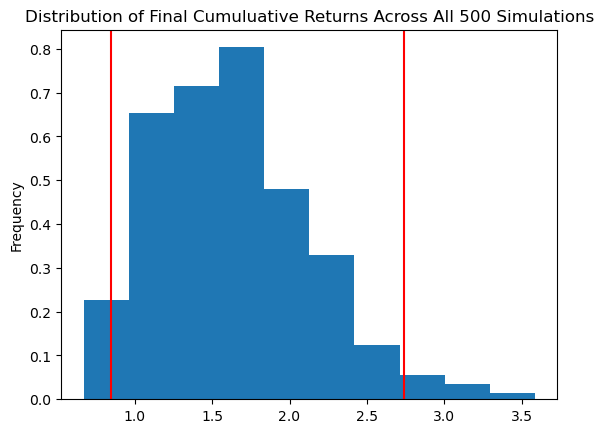

In [28]:
# Plot probability distribution and confidence intervals
dist_plot = MC_five_years.plot_distribution()

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_five_years.summarize_cumulative_return()
# Print summary statistics
print(tbl)

count           500.000000
mean              1.630278
std               0.508028
min               0.672439
25%               1.247714
50%               1.567849
75%               1.933817
max               3.584027
95% CI Lower      0.844404
95% CI Upper      2.735836
Name: 1260, dtype: float64


In [30]:
# Set initial investment
initial_investment = 60000
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl[8]* initial_investment, 2)
ci_upper_five = round(tbl[9] * initial_investment, 2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $50664.22 and $164150.16


### Ten Years Retirement Option

In [31]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# 20% weight to 'AGG', 80% weight to 'SPY' are given, and we are running simulation for 500 times for 10 years.
MC_ten_years = MCSimulation(portfolio_data = df_stock_data, weights = [0.2, 0.8], num_simulation = 500, num_trading_days = 252*10)

In [32]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002972,0.998826,0.989949,0.994004,1.017780,1.008168,0.998114,1.005572,0.997477,0.985462,...,0.998767,0.995276,1.002706,1.002161,0.995703,0.997561,1.001100,0.988142,1.011830,1.006678
2,1.001651,0.988125,0.984588,0.987399,1.017516,1.002527,0.990743,1.003895,0.997056,0.978203,...,0.999397,0.992663,1.010765,0.989355,1.006685,1.013791,0.993957,0.972608,1.023399,1.015761
3,0.995074,0.959167,0.987818,0.987588,1.018654,1.005434,0.998285,1.023822,1.008492,0.986134,...,0.974725,0.996719,1.007152,0.997753,1.003277,1.001043,1.003989,0.982473,1.031178,1.012085
4,0.987303,0.951170,0.996637,0.997847,1.016596,1.005616,0.993235,1.026091,1.008104,0.977373,...,0.967882,1.002880,1.012740,1.002385,1.019864,0.985915,0.988946,0.994035,1.021329,1.013917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.539706,2.738134,6.491197,3.441549,5.251315,4.141070,1.725586,3.268617,3.486874,1.611167,...,2.823445,2.648559,5.214658,2.679929,5.669960,2.193544,2.283912,1.963495,6.409025,1.593575
2517,1.565071,2.771485,6.451796,3.417546,5.277040,4.139042,1.717240,3.256354,3.422726,1.611197,...,2.838061,2.679721,5.236866,2.702330,5.789715,2.191895,2.270794,1.956823,6.343167,1.604818
2518,1.596792,2.717652,6.415691,3.453789,5.220153,4.162069,1.732341,3.241560,3.423565,1.628285,...,2.838988,2.625749,5.209568,2.700739,5.760825,2.198317,2.253407,1.969308,6.402535,1.589945
2519,1.587341,2.741692,6.376046,3.468034,5.072773,4.164341,1.712915,3.287128,3.427508,1.630587,...,2.848545,2.594954,5.238818,2.695443,5.740638,2.182718,2.273014,1.979988,6.343484,1.590381


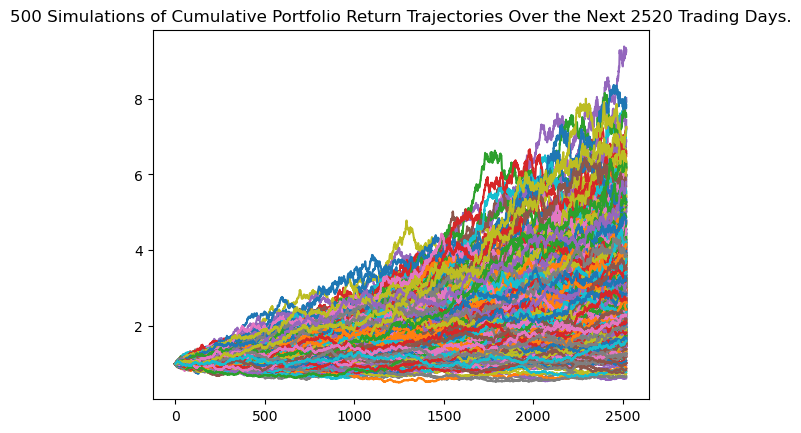

In [33]:
# Plot simulation outcomes
line_plot = MC_ten_years.plot_simulation()

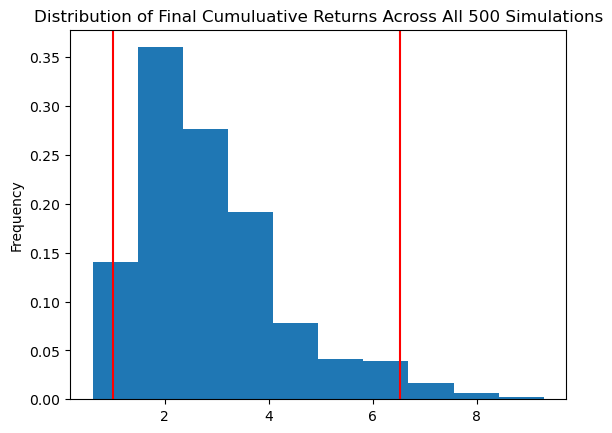

In [34]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ten_years.plot_distribution()

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_ten_years.summarize_cumulative_return()
# Print summary statistics
print(tbl)

count           500.000000
mean              2.877489
std               1.435354
min               0.621442
25%               1.817710
50%               2.576554
75%               3.624623
max               9.287611
95% CI Lower      1.008307
95% CI Upper      6.518014
Name: 2520, dtype: float64


In [36]:
# Set initial investment
initial_investment = 60000
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl[8]* initial_investment, 2)
ci_upper_ten = round(tbl[9] * initial_investment, 2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $60498.42 and $391080.82


#### Will weighting the portfolio more heavily toward stocks allow the credit union members to retire after only 5 or 10 years?

In order to answer this question, let us bring back the 95% confidence interval data for all 3 simulations that I have performed above. <br>
In order to see the effect of changing weights of the portfolio, I have set the initial investment to the same amount of $60,000 for comparison reason.


In [37]:
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" (60% weight to SPY and 40% weight to AGG)"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" (80% weight to SPY and 20% weight to AGG)"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" (80% weight to SPY and 20% weight to AGG)"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio (60% weight to SPY and 40% weight to AGG) over the next 30 years will end within in the range of $116583.78 and $1228511.03
There is a 95% chance that an initial investment of $60000 in the portfolio (80% weight to SPY and 20% weight to AGG) over the next 5 years will end within in the range of $50664.22 and $164150.16
There is a 95% chance that an initial investment of $60000 in the portfolio (80% weight to SPY and 20% weight to AGG) over the next 10 years will end within in the range of $60498.42 and $391080.82


We are not given any information about 'how much money' is enough money to retire for our clients, so the exact answer would depend on this. <br>
However, we can observe that the 95% confidence interval lower boundary for 10 years simulation is barely over the initial investment, and the 5 years simulation lower boundary is even below our initial investment. <br>
I wouldn't think any of our clinets will be happy to see near zero or even negative profit after investing for 5 - 10 years <br>
Even though on average, the 10 year simulation will give about 280% profit and 5 year simulation will give about 160% profit, if some of our clients are receiving barely any profit or negative profit, I do not think that is a well constructed portfolio for retirement plan because all of our clients will expect to earn reasonable amount of profit <br>
Therefore, I do not think weighting the portfolio more toward stocks will allow our clients to retire early.
